# RNNs - Forecasting

In this notebook you will learn how to build Recurrent Neural Networks (RNNs) for time series forecasting.


**Objectif : build RNN models for time series forecasting.**
- 1 - Time Series forecasting (Many to One) => from t-30 to t predict t+5
    - Load the data: daily temperatures in Melbourne from 1981 to 1990
    - Prepare the data: Fill the missing data
    - Add lag columns
    - Split the dataset
    - Reshape the inputs for the RNN
    - Build some basline models: naive model (predict the last known value) and linear regression
    - Build a model with 2 simple RNN layers
    - Evaluate & Plot
- 2 - Forecasting the shifted sequence (Seq2Seq - Many to Many) => from t-30 to t predict temperatures for 30 days (from t-24 to t+5) instead of just one
    - Define the 3D targets
    - Define the mae last step metric
    - Build a Seq2Seq model
    - Train the model
- 3 LSTM and GRU
    - Build, train and evaluate a Seq2Seq LSTM
    - Add l2 regularization
- 4 Preprocessing with 1D-ConvNets

# Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1 - Time series forecasting

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990.

In [3]:
data_path = 'daily-minimum-temperatures-in-me.csv'
temps = pd.read_csv(data_path,
                    parse_dates=[0], index_col=0)

In [4]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [5]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


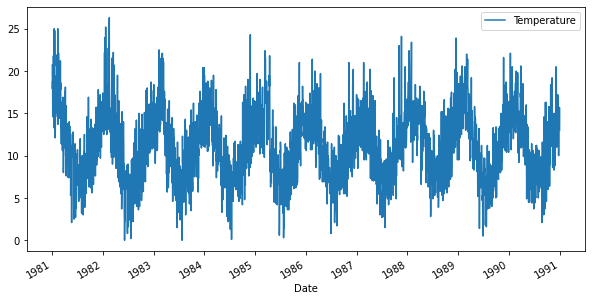

In [6]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [7]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value.

Seee : [Pandas Doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html#pandas.DataFrame.asfreq)

In [8]:
temps2 = temps.asfreq("1D", method="ffill")
temps2.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

In [9]:
temps = temps.resample('D').interpolate()
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.00
1984-12-30,16.40
1984-12-31,14.85
1985-01-01,13.30
1985-01-02,15.20


## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [10]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

In [11]:
add_lags(temps, times=(-2, -1, 0, +2)).head(10)

,t-2,t-1,t,t+2
,Temperature,Temperature,Temperature,Temperature
Date,,,,
1981-01-01,NaN,NaN,20.7,18.8
1981-01-02,NaN,20.7,17.9,14.6
1981-01-03,20.7,17.9,18.8,15.8
1981-01-04,17.9,18.8,14.6,15.8
1981-01-05,18.8,14.6,15.8,15.8
1981-01-06,14.6,15.8,15.8,17.4
1981-01-07,15.8,15.8,15.8,21.8
1981-01-08,15.8,15.8,17.4,20.0


We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [12]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [13]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [14]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


Note: you may want to use `keras.preprocessing.sequence.TimeseriesGenerator` or `tf.data.Dataset.window()` instead.

## 1.4) Split the dataset

Split this dataset into three periods: training (1981-1986), validation (1987-1988) and testing (1989-1990).

In [15]:
train_slice = slice(None, "1986-12-25")
valid_slice = slice("1987-01-01", "1988-12-25")
test_slice  = slice("1989-01-01", None)

In [16]:
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_valid, y_valid = X.loc[valid_slice], y.loc[valid_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

## 1.5) Reshape the inputs for the RNN

Keras and TensorFlow expect a 3D NumPy array for any sequence. Its shape should be (number of instances, number of time steps, number of features per time step). 

Since this is a univariate time series *(The term "univariate time series" refers to a time series that consists of single (scalar) observations recorded sequentially over equal time increments. Example : monthly CO2 concentrations)*, the last dimension is 1. 


![3D Structure](images/3D-targets.png)

Reshape the input features to get 3D arrays:

In [17]:
def multilevel_df_to_ndarray(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)

In [18]:
X_train_3D = multilevel_df_to_ndarray(X_train)
X_valid_3D = multilevel_df_to_ndarray(X_valid)
X_test_3D = multilevel_df_to_ndarray(X_test)

In [19]:
X_train.shape

(2155, 30)

In [20]:
X_train_3D.shape

(2155, 30, 1)

## 1.6) Build some baseline models

Build some baseline models (at least one) and evaluate them on the test set, using the Mean Absolute Error (MAE). For example:

* a naive model, that just predicts the last known value.
* a linear model.

Now let's evaluate some basic strategies, to get some baselines:

In [21]:
from sklearn.metrics import mean_absolute_error

In [22]:
def naive(X):
    return X.iloc[:, -1]

In [23]:
df_test = pd.DataFrame({"A" : [1,2,3,4], "B" : [11,21,31,41], "C" : [21,22,23,24]})
df_test.iloc[:, -1]

0    21
1    22
2    23
3    24
Name: C, dtype: int64

In [24]:
y_pred_naive = naive(X_test)

In [25]:
score_naive = mean_absolute_error(y_test, y_pred_naive)
score_naive

2.8064827586206893

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [28]:
y_pred_linear = lin_reg.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [29]:
score_linear = mean_absolute_error(y_test, y_pred_linear)
score_linear

2.109160325752547

Let's plot these predictions:

In [30]:
def plot_predictions(*named_predictions, start=None, end=None, **kwargs):
    day_range = slice(start, end)
    plt.figure(figsize=(10,5))
    for name, y_pred in named_predictions:
        if hasattr(y_pred, "values"):
            y_pred = y_pred.values
        plt.plot(y_pred[day_range], label=name, **kwargs)
    plt.legend()
    plt.show()

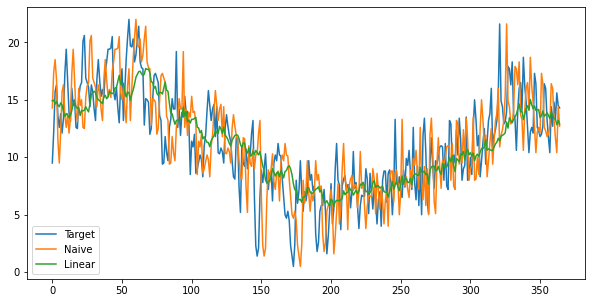

In [31]:
plot_predictions(("Target", y_test),
                 ("Naive", y_pred_naive),
                 ("Linear", y_pred_linear),
                 end=365)

## 1.7) Build a simple RNN

Using Keras, build a simple 2-layer RNN with a `memory` of 100 per layer, plus a dense layer with a single neuron. 

Train the model for 200 epochs with a batch size of 200, using Stochastic Gradient Descent with an learning rate of 0.005.

Make sure to print the validation loss during training.

Hints:

>* Create a `Sequential` model.
>* Add two `SimpleRNN` layers, with 100 units each. 
>    - The first should return sequences but not the second. 
>    - The first layer should specify the input shape (i.e., the shape of a single input sequence).
>    - Indeed, in a Seq2Vec model *(sequence of words into a fix-length representation vector.)*, the last RNN layer should not return sequences.
>* Add a Dense layer with a single neuron

![Many to One](images/many-to-one.png)
 
>* Use the MSE as the loss.
>* Use the MAE as the metric.
>* Call the model's `compile()` method, passing it an `SGD` instance with `learning_rate=0.005`.
>* Call the model's `fit()` method, with the inputs and targets, number of epochs, batch size and validation data.

In [32]:
input_shape = X_train_3D.shape[1:]
input_shape

(30, 1)

In [33]:
model_mse = keras.models.Sequential()
model_mse.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model_mse.add(keras.layers.SimpleRNN(100))
model_mse.add(keras.layers.Dense(1))
model_mse.compile(loss="mse", 
                  optimizer=keras.optimizers.SGD(learning_rate=0.005), 
                  metrics=["mae"])

In [34]:
history_mse = model_mse.fit(X_train_3D, 
                         y_train, 
                         epochs=200, 
                         batch_size=200,
                         validation_data=(X_valid_3D, y_valid))

Epoch 1/200
11/11 [==============================] - 4s 76ms/step - loss: 28.2816 - mae: 3.9600 - val_loss: 15.7237 - val_mae: 3.1429
Epoch 2/200
11/11 [==============================] - 1s 57ms/step - loss: 14.1141 - mae: 2.9563 - val_loss: 10.3223 - val_mae: 2.5271
Epoch 3/200
11/11 [==============================] - 1s 97ms/step - loss: 14.8026 - mae: 3.0022 - val_loss: 17.0856 - val_mae: 3.3574
Epoch 4/200
11/11 [==============================] - 1s 113ms/step - loss: 14.3630 - mae: 2.9823 - val_loss: 11.0989 - val_mae: 2.6073
Epoch 5/200
11/11 [==============================] - 2s 142ms/step - loss: 12.0575 - mae: 2.7283 - val_loss: 9.8611 - val_mae: 2.4623
Epoch 6/200
11/11 [==============================] - 1s 123ms/step - loss: 12.2234 - mae: 2.7352 - val_loss: 9.7425 - val_mae: 2.4571
Epoch 7/200
11/11 [==============================] - 1s 124ms/step - loss: 11.6693 - mae: 2.6748 - val_loss: 15.0905 - val_mae: 3.1314
Epoch 8/200
11/11 [==============================] - 1s 116m

In [35]:
X_train_3D.shape

(2155, 30, 1)

## 1.8) Plot the history

You can simply use `pd.DataFrame(history.history).plot()`.

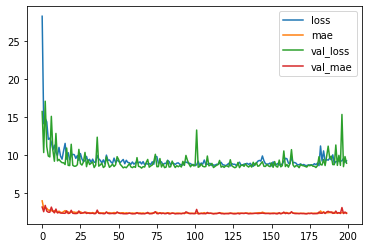

In [36]:
pd.DataFrame(history_mse.history).plot()

If you want to add some legends, colors, etc. or select only loss, you have to specify that!

In [ ]:
def plot_history(history, variable="loss"):
    train_var = history.history[variable]
    valid_var = history.history["val_" + variable]
    n_epochs = len(history.epoch)
    min_var = np.min(valid_var)
    max_var = np.max(history.history[variable] + history.history["val_" + variable]) + 2
    
    plt.plot(train_var, color="b", label="Train")
    plt.plot(valid_var, color="r", label="Validation")
    plt.plot([0, n_epochs], [min_var, min_var], "k--",
             label="Min val: {:.2f}".format(min_var))
    plt.axis([0, n_epochs, 0, max_var])
    plt.legend()
    plt.show()

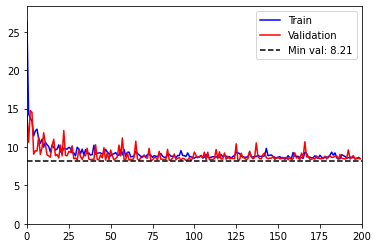

In [ ]:
plot_history(history_mse)

## 1.9) Evaluate the model

Evaluate your RNN on the test set, using the MAE. Try training your model again using the Huber loss and see if you get better performance.

*In statistics, the Huber loss is a loss function used in robust regression, that is less sensitive to outliers in data than the squared error loss.*

In [ ]:
score_mse = model_mse.evaluate(X_test_3D, y_test)
score_mse

23/23 [==============================] - 0s 7ms/step - loss: 7.4405 - mae: 2.1254


[7.440540313720703, 2.125441074371338]

In [ ]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [ ]:
model_huber = keras.models.Sequential()
model_huber.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model_huber.add(keras.layers.SimpleRNN(100))
model_huber.add(keras.layers.Dense(1))
model_huber.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.005), metrics=["mae"])

In [ ]:
history_huber = model_huber.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

Epoch 1/200
11/11 [==============================] - 3s 126ms/step - loss: 6.1282 - mae: 6.6170 - val_loss: 3.6400 - val_mae: 4.1196
Epoch 2/200
11/11 [==============================] - 1s 91ms/step - loss: 3.0373 - mae: 3.5076 - val_loss: 2.5823 - val_mae: 3.0463
Epoch 3/200
11/11 [==============================] - 1s 51ms/step - loss: 2.6526 - mae: 3.1174 - val_loss: 2.4174 - val_mae: 2.8770
Epoch 4/200
11/11 [==============================] - 1s 47ms/step - loss: 2.5683 - mae: 3.0296 - val_loss: 2.3509 - val_mae: 2.8091
Epoch 5/200
11/11 [==============================] - 1s 46ms/step - loss: 2.4968 - mae: 2.9571 - val_loss: 2.2932 - val_mae: 2.7520
Epoch 6/200
11/11 [==============================] - 1s 48ms/step - loss: 2.4174 - mae: 2.8791 - val_loss: 2.2213 - val_mae: 2.6794
Epoch 7/200
11/11 [==============================] - 1s 51ms/step - loss: 2.3345 - mae: 2.7964 - val_loss: 2.1436 - val_mae: 2.6011
Epoch 8/200
11/11 [==============================] - 1s 51ms/step - loss: 2

In [ ]:
score_huber = model_huber.evaluate(X_test_3D, y_test)
score_huber

23/23 [==============================] - 0s 6ms/step - loss: 1.6662 - mae: 2.1068


[1.6661920547485352, 2.106822967529297]

## 1.10) Plot the predictions

Make predictions on the test set and plot them. Compare them to the targets and the baseline predictions.

In [ ]:
y_pred_rnn_huber = model_huber.predict(X_test_3D)
y_pred_rnn_mse = model_mse.predict(X_test_3D)

23/23 [==============================] - 0s 6ms/step


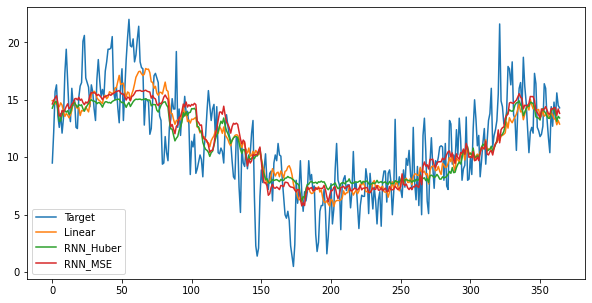

In [ ]:
plot_predictions(("Target", y_test),
                 ("Linear", y_pred_linear),
                 ("RNN_Huber", y_pred_rnn_huber),
                 ("RNN_MSE", y_pred_rnn_mse),
                 end=365)

# 2 - Forecasting the shifted sequence (Seq2Seq)
Now let's predict temperatures for 30 days (from t-24 to t+5) instead of just one.

![Many to Many](images/many-to-many.png)

## 2.1) Define the 3D targets for training, validation and testing

In [ ]:
Y = add_lags(temps, times=range(-24, 5+1)).iloc[30:-5]
Y_train = Y.loc[train_slice]
Y_valid = Y.loc[valid_slice]
Y_test = Y.loc[test_slice]
Y_train_3D = multilevel_df_to_ndarray(Y_train)
Y_valid_3D = multilevel_df_to_ndarray(Y_valid)
Y_test_3D = multilevel_df_to_ndarray(Y_test)
Y_test_3D.shape

(725, 30, 1)

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5). Create an `mae_last_step()` function that computes the MAE based on the final time step.

In [ ]:
K = keras.backend

def mae_last_step(Y_true, Y_pred):
    return K.mean(K.abs(Y_pred[:, -1] - Y_true[:, -1]))

## 2.3) Build a Seq2Seq model

Build a Seq2Seq model and compile it, using the Huber Loss, and using the last step MAE as the metric. Use SGD with a learning rate of 0.01. 

>Hint: the layers are the same as earlier, except that the last RNN layer has `return_sequences=True`.

In [ ]:
modelSeq2Seq = keras.models.Sequential()
modelSeq2Seq.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
modelSeq2Seq.add(keras.layers.SimpleRNN(100, return_sequences=True))
modelSeq2Seq.add(keras.layers.Dense(1))
modelSeq2Seq.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.01),
               metrics=[mae_last_step])
modelSeq2Seq.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 30, 100)           10200     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 30, 100)           20100     
                                                                 
 dense_2 (Dense)             (None, 30, 1)             101       
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


## 2.4) Train the model

Fit the model as earlier (but with the 3D targets). Again, evaluate the model and plot the predictions.

In [ ]:
historySeq2Seq = modelSeq2Seq.fit(X_train_3D, 
                                  Y_train_3D, 
                                  epochs=200, 
                                  batch_size=200,
                                  validation_data=(X_valid_3D, Y_valid_3D))

Epoch 1/200
11/11 [==============================] - 2s 78ms/step - loss: 4.6905 - mae_last_step: 4.9934 - val_loss: 2.5706 - val_mae_last_step: 2.9562
Epoch 2/200
11/11 [==============================] - 1s 46ms/step - loss: 2.7008 - mae_last_step: 3.0461 - val_loss: 2.3712 - val_mae_last_step: 2.7796
Epoch 3/200
11/11 [==============================] - 1s 50ms/step - loss: 2.5614 - mae_last_step: 2.9348 - val_loss: 2.2605 - val_mae_last_step: 2.6854
Epoch 4/200
11/11 [==============================] - 1s 47ms/step - loss: 2.4286 - mae_last_step: 2.8115 - val_loss: 2.1515 - val_mae_last_step: 2.5871
Epoch 5/200
11/11 [==============================] - 1s 47ms/step - loss: 2.3015 - mae_last_step: 2.6826 - val_loss: 2.0711 - val_mae_last_step: 2.5163
Epoch 6/200
11/11 [==============================] - 1s 48ms/step - loss: 2.1933 - mae_last_step: 2.5834 - val_loss: 1.9964 - val_mae_last_step: 2.4383
Epoch 7/200
11/11 [==============================] - 1s 51ms/step - loss: 2.1187 - mae_l

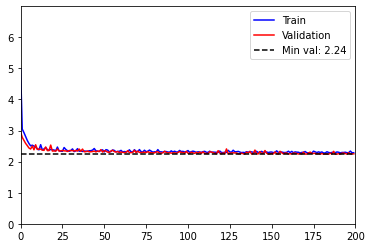

In [ ]:
plot_history(historySeq2Seq, variable="mae_last_step")

In [ ]:
score_seq2seq = modelSeq2Seq.evaluate(X_test_3D, y_test)
score_seq2seq

23/23 [==============================] - 0s 7ms/step - loss: 1.8883 - mae_last_step: 2.1029


[1.8883044719696045, 2.1029014587402344]

In [ ]:
y_pred_seq2seq = modelSeq2Seq.predict(X_test_3D)[:, -1]

23/23 [==============================] - 0s 6ms/step


In [ ]:
modelSeq2Seq.predict(X_test_3D).shape

23/23 [==============================] - 0s 7ms/step


(725, 30, 1)

In [ ]:
y_pred_seq2seq.shape

(725, 1)

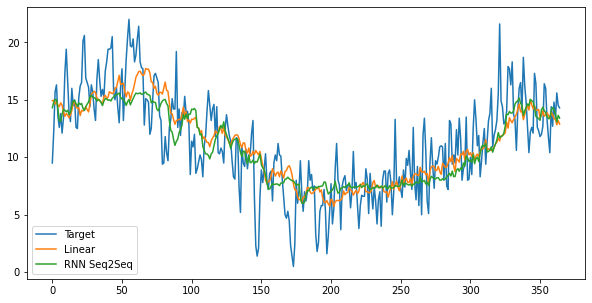

In [ ]:
plot_predictions(("Target", y_test),
                 ("Linear", y_pred_linear),
                 ("RNN Seq2Seq", y_pred_seq2seq),
                 end=365)

# 3 – LSTM and GRU

## 3.1) Build, train and evaluate a Seq2Seq LSTM

Train the same model as earlier but using `LSTM` or `GRU` instead of `SimpleRNN`. You can also try reducing the learning rate when the validation loss reaches a plateau, using the `ReduceLROnPlateau` callback.

You can try replacing `LSTM` with `GRU`.

In [ ]:
modelSeq2SeqLSTM = keras.models.Sequential()
modelSeq2SeqLSTM.add(keras.layers.LSTM(100, return_sequences=True, input_shape=input_shape))
modelSeq2SeqLSTM.add(keras.layers.LSTM(100, return_sequences=True))
modelSeq2SeqLSTM.add(keras.layers.Dense(1))
modelSeq2SeqLSTM.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.01),
               metrics=[mae_last_step])

In [ ]:
historySeq2SeqLSTM = modelSeq2SeqLSTM.fit(X_train_3D, 
                                          Y_train_3D, 
                                          epochs=200, 
                                          batch_size=200,
                                          validation_data=(X_valid_3D, Y_valid_3D),
                                          callbacks=[keras.callbacks.ReduceLROnPlateau(verbose=1)])

Epoch 1/200
11/11 [==============================] - 6s 86ms/step - loss: 9.0792 - mae_last_step: 9.2399 - val_loss: 7.8042 - val_mae_last_step: 7.8715 - lr: 0.0100
Epoch 2/200
11/11 [==============================] - 0s 16ms/step - loss: 6.2983 - mae_last_step: 6.0975 - val_loss: 5.1654 - val_mae_last_step: 4.9661 - lr: 0.0100
Epoch 3/200
11/11 [==============================] - 0s 15ms/step - loss: 4.2715 - mae_last_step: 3.9841 - val_loss: 3.5721 - val_mae_last_step: 3.3604 - lr: 0.0100
Epoch 4/200
11/11 [==============================] - 0s 13ms/step - loss: 3.3871 - mae_last_step: 3.2317 - val_loss: 3.0345 - val_mae_last_step: 2.9272 - lr: 0.0100
Epoch 5/200
11/11 [==============================] - 0s 12ms/step - loss: 3.1570 - mae_last_step: 3.1189 - val_loss: 2.8961 - val_mae_last_step: 2.8593 - lr: 0.0100
Epoch 6/200
11/11 [==============================] - 0s 12ms/step - loss: 3.0932 - mae_last_step: 3.1245 - val_loss: 2.8425 - val_mae_last_step: 2.8343 - lr: 0.0100
Epoch 7/20

In [ ]:
score_seq2seq_LSTM = modelSeq2SeqLSTM.evaluate(X_test_3D, Y_test_3D)
score_seq2seq_LSTM

23/23 [==============================] - 0s 4ms/step - loss: 1.7881 - mae_last_step: 2.1116


[1.7881419658660889, 2.111649990081787]

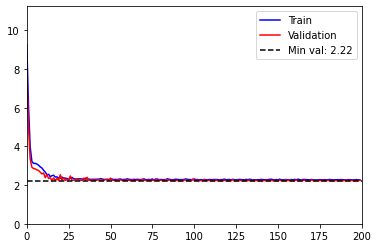

In [ ]:
plot_history(historySeq2SeqLSTM, variable="mae_last_step")

In [ ]:
y_pred_Seq2SeqLSTM = modelSeq2SeqLSTM.predict(X_test_3D)[:, -1]

23/23 [==============================] - 1s 4ms/step


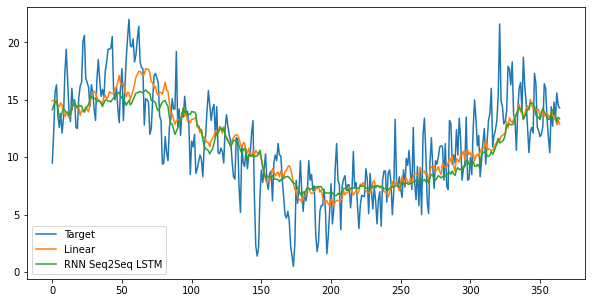

In [ ]:
plot_predictions(("Target", y_test),
                 ("Linear", y_pred_linear),
                 ("RNN Seq2Seq LSTM", y_pred_Seq2SeqLSTM),
                 end=365)

## 3.2) Add $\ell_2$ regularization

Add $\ell_2$ regularization to your RNN, using the layers' `kernel_regularizer` and `recurrent_regularizer` arguments, and the `l2()` function in `keras.regularizers`. Tip: use the `partial()` function in the `functools` package to avoid repeating the same arguments again and again.

[More information on $\ell_1$ and $\ell_2$ regularization](https://inside-machinelearning.com/regularization-deep-learning/)

In [ ]:
from functools import partial

In [ ]:
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))

#reg_lstm_layer = keras.layers.LSTM(units= 100,
#                                   return_sequences=True,
#                                   kernel_regularizer=keras.regularizers.l2(1e-4),
#                                   recurrent_regularizer=keras.regularizers.l2(1e-4))

In [ ]:
modelSeq2SeqLSTM_reg = keras.models.Sequential()
modelSeq2SeqLSTM_reg.add(RegularizedLSTM(100, input_shape=input_shape))
modelSeq2SeqLSTM_reg.add(RegularizedLSTM(100))
modelSeq2SeqLSTM_reg.add(keras.layers.Dense(1))
modelSeq2SeqLSTM_reg.compile(loss=huber_loss, 
                             optimizer=keras.optimizers.SGD(learning_rate=0.01),
                             metrics=[mae_last_step])

In [ ]:
historySeq2SeqLSTM_reg = modelSeq2SeqLSTM_reg.fit(X_train_3D, 
                                    Y_train_3D, 
                                    epochs=200, 
                                    batch_size=100,
                                    validation_data=(X_valid_3D, Y_valid_3D))

Epoch 1/200
22/22 [==============================] - 5s 87ms/step - loss: 7.3886 - mae_last_step: 7.2022 - val_loss: 5.0470 - val_mae_last_step: 5.1273
Epoch 2/200
22/22 [==============================] - 0s 11ms/step - loss: 3.8186 - mae_last_step: 3.5906 - val_loss: 3.0520 - val_mae_last_step: 3.1021
Epoch 3/200
22/22 [==============================] - 0s 11ms/step - loss: 3.1362 - mae_last_step: 3.1002 - val_loss: 2.8476 - val_mae_last_step: 2.9494
Epoch 4/200
22/22 [==============================] - 0s 10ms/step - loss: 3.0401 - mae_last_step: 3.0677 - val_loss: 2.7674 - val_mae_last_step: 2.8835
Epoch 5/200
22/22 [==============================] - 0s 11ms/step - loss: 2.9196 - mae_last_step: 2.9336 - val_loss: 2.6098 - val_mae_last_step: 2.6844
Epoch 6/200
22/22 [==============================] - 0s 10ms/step - loss: 2.6972 - mae_last_step: 2.6562 - val_loss: 2.4932 - val_mae_last_step: 2.7528
Epoch 7/200
22/22 [==============================] - 0s 11ms/step - loss: 2.5544 - mae_l

In [ ]:
score_seq2seq_LSTM_reg = modelSeq2SeqLSTM_reg.evaluate(X_test_3D, Y_test_3D)
score_seq2seq_LSTM_reg

23/23 [==============================] - 0s 4ms/step - loss: 1.7941 - mae_last_step: 2.1227


[1.794054627418518, 2.1226987838745117]

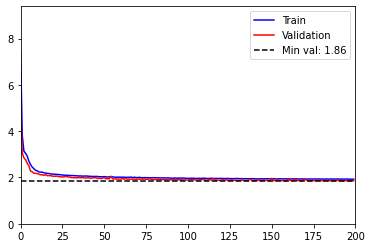

In [ ]:
plot_history(historySeq2SeqLSTM_reg)

In [ ]:
y_pred_seq2seq_lstm_reg = modelSeq2SeqLSTM_reg.predict(X_test_3D)[:, -1]

23/23 [==============================] - 1s 4ms/step


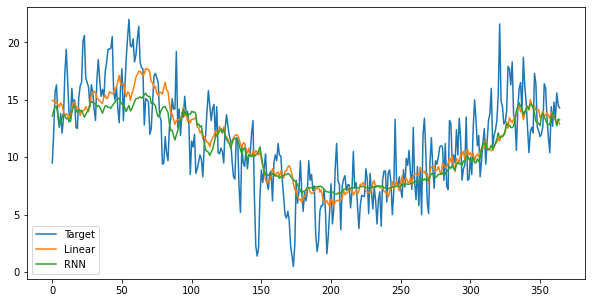

In [ ]:
plot_predictions(("Target", y_test),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_seq2seq_lstm_reg),
                 end=365)

# 4 – Preprocessing with 1D-ConvNets

At the beginning of your sequential model, add a `Conv1D` layer with 32 kernels of size 5, a `MaxPool1D` layer with pool size 5 and strides 2. Train and evaluate the model.

In [ ]:
model_conv1D_lstm = keras.models.Sequential()
model_conv1D_lstm.add(keras.layers.Conv1D(32, kernel_size=5, input_shape=input_shape))
model_conv1D_lstm.add(keras.layers.MaxPool1D(pool_size=5, strides=2))
model_conv1D_lstm.add(keras.layers.LSTM(32, return_sequences=True))
model_conv1D_lstm.add(keras.layers.LSTM(32))
model_conv1D_lstm.add(keras.layers.Dense(1))
model_conv1D_lstm.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.005))

In [ ]:
model_conv1D_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 11, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
__________________________________________________

In [ ]:
history4 = model_conv1D_lstm.fit(X_train_3D, 
                                 y_train, 
                                 epochs=200, 
                                 batch_size=100,
                                 validation_data=(X_valid_3D, y_valid))

Epoch 1/200
22/22 [==============================] - 7s 50ms/step - loss: 9.6992 - val_loss: 9.1665
Epoch 2/200
22/22 [==============================] - 0s 7ms/step - loss: 8.0356 - val_loss: 7.6793
Epoch 3/200
22/22 [==============================] - 0s 9ms/step - loss: 6.6212 - val_loss: 6.2328
Epoch 4/200
22/22 [==============================] - 0s 7ms/step - loss: 5.2584 - val_loss: 4.8277
Epoch 5/200
22/22 [==============================] - 0s 9ms/step - loss: 4.0884 - val_loss: 3.7310
Epoch 6/200
22/22 [==============================] - 0s 7ms/step - loss: 3.3315 - val_loss: 3.0561
Epoch 7/200
22/22 [==============================] - 0s 7ms/step - loss: 2.9413 - val_loss: 2.7192
Epoch 8/200
22/22 [==============================] - 0s 8ms/step - loss: 2.7518 - val_loss: 2.5379
Epoch 9/200
22/22 [==============================] - 0s 7ms/step - loss: 2.6233 - val_loss: 2.4060
Epoch 10/200
22/22 [==============================] - 0s 9ms/step - loss: 2.5591 - val_loss: 2.4077
Epoch 11

In [ ]:
score_conv1D_lstm = model_conv1D_lstm.evaluate(X_test_3D, y_test)
score_conv1D_lstm

23/23 [==============================] - 0s 4ms/step - loss: 1.7938


1.7937922477722168

# 5 – Comparaison des modeles

In [ ]:

df_res = pd.DataFrame({"Model" : 
                      ["Naive", "Linear", "RNN Huber", "RNN MSE", "Seq2Seq", "Seq2Seq LSTM", 
                       "Seq2Seq LSTM Reg", "Conv1D"],
                       "Loss" : [score_naive, score_linear, score_huber[1], score_mse[1], score_seq2seq[1], 
                       score_seq2seq_LSTM[1], score_seq2seq_LSTM_reg[1] , score_conv1D_lstm]})

df_res

,Model,Loss
0,Naive,2.806483
1,Linear,2.109160
2,RNN Huber,2.106823
3,RNN MSE,2.125441
4,Seq2Seq,2.102901
5,Seq2Seq LSTM,2.111650
6,Seq2Seq LSTM Reg,2.122699
7,Conv1D,1.793792
